In [211]:
# Import Library
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import joblib
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, GlobalMaxPool1D, Bidirectional, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [212]:
with open('dataset.json') as content:
  data = json.load(content)

In [213]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [214]:
# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])


In [215]:
joblib.dump(responses, 'responses.pkl')

['responses.pkl']

In [216]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(inputs, tags,test_size=0.2, random_state=20)

# Konversi data ke dalam dataframe
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [217]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  296 non-null    object
 1   tags      296 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [218]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  75 non-null     object
 1   tags      75 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [219]:
train_data.describe()

,patterns,tags
count,296,296
unique,293,59
top,gangguan makan,selamat datang
freq,2,16


In [220]:
test_data.describe()

,patterns,tags
count,75,75
unique,75,40
top,siang,selamat datang
freq,1,6


In [221]:
train_data.head()

,patterns,tags
0,frustasi itu apa?,frustasi
1,apa itu bunuh diri?,pengertian bunuh diri
2,penyebab depresi apa?,penyebab depresi
3,meredakan depresi,cara menangani depresi
4,bye,selamat tinggal


In [222]:
test_data.head()

,patterns,tags
0,siang,selamat datang
1,Mengatasi trauma psikologis,mengatasi trauma
2,penyebab bipolar apa?,penyebab gangguan bipolar
3,mengatasi kesepian,cara mengatasi kesepian
4,dukungan teman untuk orang dengan gangguan kes...,dukungan teman


In [223]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [224]:
# Inisialisasi Lemmatizer
lemmatizer = WordNetLemmatizer()

# Fungsi untuk melakukan lemmatization pada kata-kata dalam kalimat
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenisasi kata-kata dalam kalimat
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    lemmatized_text = ' '.join(lemmatized_tokens)  # Menggabungkan kembali kata-kata menjadi kalimat
    return lemmatized_text

# Contoh penggunaan fungsi lemmatize_text pada dataset
train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [225]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

x_train = tokenizer.texts_to_sequences(train_data['patterns'])
x_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [226]:
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

In [227]:
# Apply padding
max_sequence_length = max(len(seq) for seq in x_train + x_test)
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [228]:
joblib.dump(max_sequence_length, 'max_sequence_length.pkl')

['max_sequence_length.pkl']

In [229]:
# Combine tags from train_data and test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

# Encoding the outputs
le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [230]:
joblib.dump(le, 'le.pkl')

['le.pkl']

In [231]:
# Splitting the dataset
train_dataset = (x_train, y_train)
test_dataset = (x_test, y_test)

In [232]:
# Creating the model
# Menambahkan regularisasi L2
regularization = regularizers.l2(0.01)

# Mengubah tingkat dropout menjadi 0.4
dropout_rate = 0.5

# Mendefinisikan input layer
i = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_size = 100
x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(i)

# Bidirectional LSTM layer
lstm_units = 32
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)

# Bidirectional GRU layer
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

# Flatten layer
x = Flatten()(x)

# Dense layer with L2 regularization
dense_units = 50
x = Dense(dense_units, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(dropout_rate)(x)

# Output layer
num_classes = len(classes)
x = Dense(num_classes, activation="softmax")(x)
model = Model(i, x)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 10, 100)           17500     
                                                                 
 bidirectional_14 (Bidirecti  (None, 10, 64)           34048     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 10, 128)          49920     
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 50)                6405

In [233]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.98:
            print("\nReached 0.7 val acc so cancelling training!")

            # Stop training once the above condition is met
            self.model.stop_training = True

In [234]:
# Instantiate the callback class
cb = myCallback()

In [235]:
learning_rate = 0.001

In [236]:
optimizer = Adam(learning_rate=learning_rate)

In [237]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [238]:
# Training the model
history = model.fit(train_dataset[0], train_dataset[1], batch_size = 20, epochs=200, callbacks = [cb], validation_data=test_dataset)

Epoch 1/200


15/15 [==============================] - 27s 371ms/step - loss: 4.7918 - accuracy: 0.0304 - val_loss: 4.5545 - val_accuracy: 0.0933
Epoch 2/200
15/15 [==============================] - 1s 55ms/step - loss: 4.4128 - accuracy: 0.0372 - val_loss: 4.2844 - val_accuracy: 0.0800
Epoch 3/200
15/15 [==============================] - 1s 53ms/step - loss: 4.2035 - accuracy: 0.0574 - val_loss: 4.1692 - val_accuracy: 0.0800
Epoch 4/200
15/15 [==============================] - 1s 57ms/step - loss: 4.0991 - accuracy: 0.0574 - val_loss: 4.1028 - val_accuracy: 0.0800
Epoch 5/200
15/15 [==============================] - 1s 55ms/step - loss: 3.9791 - accuracy: 0.0473 - val_loss: 3.9351 - val_accuracy: 0.0933
Epoch 6/200
15/15 [==============================] - 1s 56ms/step - loss: 3.7807 - accuracy: 0.0676 - val_loss: 3.7562 - val_accuracy: 0.0933
Epoch 7/200
15/15 [==============================] - 1s 62ms/step - loss: 3.6093 - accuracy: 0.1014 - val_loss: 3.6299 - val_accuracy: 0.0533
Epoch 8/200
15/1

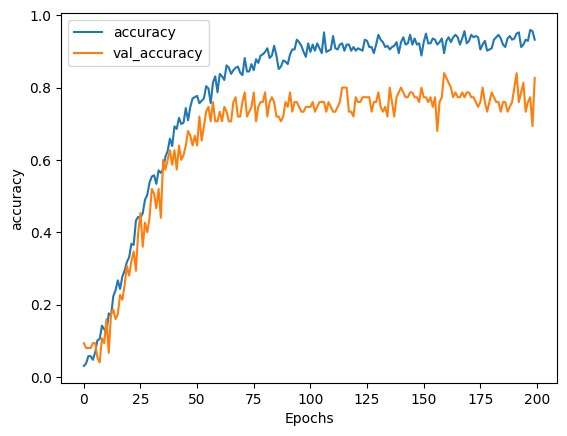

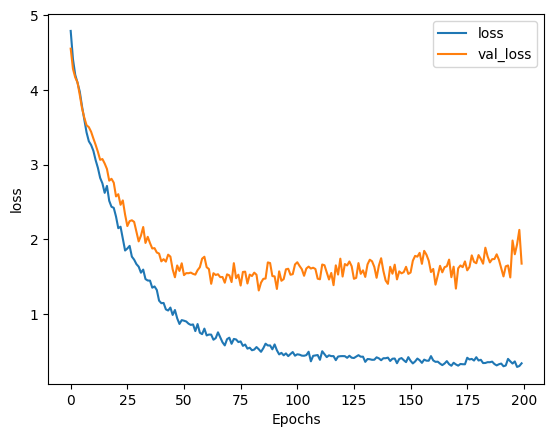

In [239]:
#diisi dengan plot hasil accuray dan loss training dan testing


# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [240]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],max_sequence_length)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print("🤖 ChatbotX :",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

KeyboardInterrupt: Interrupted by user

In [ ]:
#save model h5
model.save('model.h5')

In [ ]:
# #konversi model h5 ke tflite untuk deployment
# # Load the Keras model from the .h5 file
# model = tf.keras.models.load_model('model.h5')

# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter._experimental_lower_tensor_list_ops = False
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model to a .tflite file
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)